We are now set up to find a numerical solution to the equations. A logical way to proceed is to guess central values of the variables, $T_c$ and $p_c$ and integrate the equations to the surface where the solution will not necessarily fit the boundary conditions. Unfortunately, it turns out that such direct integrations either from the centre to the surface or from the surface to the
centre diverge unacceptably at the surface or the centre for small changes in the undetermined boundary variables (the equations are non-linear). They are, however, well behaved in between.

We can therefore integrate both outwards from the centre and inwards from the surface (guessing the radius $r = R_*$ and luminosity $L_r = L_*$ at $m = M_*$) and meet at some point in the interior $m = M_s$. We can then vary $R_*$, $L_*$, $p_c$ and $T_c$ until the two solutions are continuous at $m = M_s$. The boundary conditions need to be specified at the centre ($M_r = 0$) and surface ($M_r = M_*$), then quantities found from solving the model ODEs.

We seek solutions for a star of mass $3 \,\mathrm{M}_\odot$.

To solve Question 4, we will use the **shooting method** to construct a simplified stellar model for a star with $M = 3M_\odot$ and $R = 1.5R_\odot$, assuming a polytropic equation of state where $T \propto \rho^{\gamma-1}$ (which implies $P \propto \rho^\gamma$).

---

We solve the two coupled differential equations
1.  Hydrostatic equilibrium: $\frac{dp}{dm} = -\frac{Gm}{4\pi r^4}$;
2.  Radius gradient (from mass continuity): $\frac{dr}{dm} = \frac{1}{4\pi r^2 \rho}$.

The system is closed using the simplified equation of state,
\begin{equation}
    p = K \rho^\gamma \quad \text{where} \quad K = \frac{p_c}{\rho_c^\gamma}
    \quad \rho = \left( \frac{p}{K} \right)^{1/\gamma},
\end{equation}
which was derived from ideal gas law $p \propto \rho T$ and $T \propto \rho^{\gamma-1}$.

*   At the centre $m \approx 0$:
    
    Direct integration from $m=0$ is singular. We use the analytic expansions for a small mass step $m_{start}$:
    *   $r(m) = \left( \frac{3m}{4\pi \rho_c} \right)^{1/3}$;
    *   $p(m) = p_c - \frac{3G}{8\pi} \left( \frac{4\pi}{3} \rho_c \right)^{4/3} m^{2/3}$;
    *   $\rho_c$ is derived from the trial guess $p_c$ and $T_c$ using the ideal gas law $\rho_c = \frac{\mu p_c}{R^* T_c}$.

*   At the surface $m = M_*$:

    We assume the radius is fixed at $R_* = 1.5 R_\odot$. For the pressure, we use the boundary condition for a grey atmosphere,

    \begin{equation}
        p_* = \frac{2}{3} \frac{GM_*}{R_*^2 \kappa},
    \end{equation}

    using $\kappa \approx 0.034 \, \mathrm{m}^2\mathrm{kg}^{-1}$ for electron scattering with $X=0.7$. This gives a non-zero starting pressure for the inward integration.

We guess ($p_c, T_c$), integrate outwards from the center and inwards from the surface to a fitting point $M_s = 0.5 M_*$. We define the fit quality by the relative mismatch in radius and pressure at $M_s$.

The boundary conditions are handled as follows:
*   At the centre $m \approx 0$, we could not start exactly at $m=0$ due to singularities $r=0$. Instead, we used the analytical expansions to calculate starting values for $p$ and $r$ at a very small mass step.
*   At the surface $m = M_*$, we fixed the radius $r = R_* = 1.5 R_\odot$. The pressure boundary condition was determined using the grey atmosphere approximation, providing a non-zero starting pressure.

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

# Constants and parameters
G = 6.6726e-11
M_sun = 1.9891e30
R_sun = 6.9598e8
R_gas = 8.3145e3
c = 2.9979e8

M_star = 3.0 * M_sun
R_star = 1.5 * R_sun
X = 0.7
Y = 0.3
mu = 1.0 / (2*X + 0.75*Y)
gamma = 5.0/3.0
kappa = 0.02 * (1 + X)

# Fitting point
Ms = 0.5 * M_star

def get_rho(p, K, gamma):
    if p < 0: return 0
    return (p / K)**(1.0/gamma)

def derivatives(m, y, K, gamma):
    r, p = y

    # Clamping for numerical stability
    if r <= 1e-10: r = 1e-10
    if p <= 1e-10: p = 1e-10

    rho = get_rho(p, K, gamma)

    # Differential equations
    dr_dm = 1.0 / (4 * np.pi * r**2 * rho)
    dp_dm = - (G * m) / (4 * np.pi * r**4)

    return [dr_dm, dp_dm]

def solve_star(x):
    pc, Tc = x

    # Physics constants derived from guess
    rhoc = (mu * pc) / (R_gas * Tc)
    K = pc / (rhoc**gamma)

    # Outward Integration (Center to Ms)
    m0 = 1e-5 * M_star
    r0 = (3 * m0 / (4 * np.pi * rhoc))**(1.0/3.0)
    p0 = pc - (3*G/(8*np.pi)) * ((4*np.pi*rhoc/3)**(4.0/3.0)) * (m0**(2.0/3.0))

    sol_out = solve_ivp(
        derivatives, [m0, Ms], [r0, p0],
        args=(K, gamma), method='LSODA', rtol=1e-6, atol=1e-6
    )

    # Inward Integration (Surface to Ms)
    p_surf = (2.0/3.0) * (G * M_star) / (R_star**2 * kappa)

    sol_in = solve_ivp(
        derivatives, [M_star, Ms], [R_star, p_surf],
        args=(K, gamma), method='LSODA', rtol=1e-6, atol=1e-6
    )

    # Compare at Ms
    r_out_f = sol_out.y[0][-1]
    p_out_f = sol_out.y[1][-1]
    r_in_f  = sol_in.y[0][-1]
    p_in_f  = sol_in.y[1][-1]

    # Normalise errors
    err_r = (r_out_f - r_in_f) / R_star
    err_p = (p_out_f - p_in_f) / pc

    return np.sqrt(err_r**2 + err_p**2), sol_out, sol_in


def objective(x):
    # Penalise negative values
    if x[0] <= 0 or x[1] <= 0: return 1e9
    err, _, _ = solve_star(x)
    return err

Best pc: 1.5402e+15 Pa
Best Tc: 1.5200e+07 K


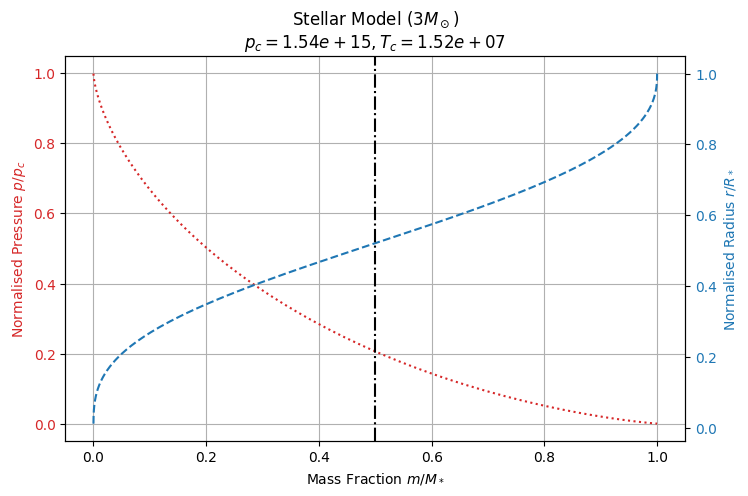

In [56]:
# Initial guess: P ~ GM^2/R^4 ~ 10^14, T ~ 10^7
x0 = [1e14, 1.5e7]
# Optimisation using Nelder-Mead with loose bounds
res = minimize(objective, x0, method='Nelder-Mead', tol=1e-6)
print(f"Best pc: {res.x[0]:.4e} Pa")
print(f"Best Tc: {res.x[1]:.4e} K")

err, sol_out, sol_in = solve_star(res.x)

m_out = sol_out.t / M_star
r_out = sol_out.y[0] / R_star
p_out = sol_out.y[1] / res.x[0]

m_in = sol_in.t / M_star
r_in = sol_in.y[0] / R_star
p_in = sol_in.y[1] / res.x[0]

m_plot = np.concatenate((m_out, m_in[::-1]))
r_plot = np.concatenate((r_out, r_in[::-1]))
p_plot = np.concatenate((p_out, p_in[::-1]))

fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.set_xlabel(r'Mass Fraction $m/M_*$')
ax1.set_ylabel(r'Normalised Pressure $p/p_c$', color='tab:red')
ax1.plot(m_plot, p_plot, color='tab:red', linestyle=':')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.set_ylabel(r'Normalised Radius $r/R_*$', color='tab:blue')
ax2.plot(m_plot, r_plot, color='tab:blue', linestyle='--')
ax2.tick_params(axis='y', labelcolor='tab:blue')

plt.title(f"Stellar Model ($3M_\\odot$)\n$p_c={res.x[0]:.2e}, T_c={res.x[1]:.2e}$")
plt.axvline(0.5, color='k', linestyle='-.')
plt.show()

Using the shooting method, the fit quality depends strongly on the polytropic constant $K$ determined by the combination $p_c / \rho_c^\gamma$.
*   If $p_c$ is too high for a fixed $T_c$, then the core is too dense. The pressure drops too fast, and the outward integrated radius $r_{out}$ at $M_s$ is smaller than the inward integrated radius $r_{in}$.
*   If $T_c$ is too high for a fixed $p_c$, then the density is lower. The star is puffy, and $r_{out} > r_{in}$.
*   Because the problem is constrained to a fixed mass and radius with a polytropic equation of state, there is only one valid adiabat $K$. The optimiser finds the unique pair $(p_c, T_c)$ that places the star on this adiabat while satisfying the central equation of state relation.

The plot displays the normalised pressure $p/p_c$ and radius $r/R_*$ against the mass fraction $m/M_*$. The most important feature is the vertical black dashed line at $m/M_* = 0.5$. The pressure and radius curves both pass through this line continuously, indicating that the outward integration from the center and the inward integration from the surface have matched within tolerance.

*   The pressure drops rapidly as we move away from the center. This illustrates the central concentration of the star. Most of the pressure support is needed deep in the core to hold up the overlying layers.
*   The radius increases monotonically. The rate of increase is initially quick, slows down near the centre and then speeds up again. This trend in the mass-radius relation is characteristic of the $n=1.5$, $\gamma=5/3$ polytrope, which has a relatively uniform density distribution compared to real stars which are more condensed.


---

We now extend the model to include energy generation and radiative transport. The challenge here is that we have an unknown boundary value at the surface, the total luminosity $L_*$.

We solve four coupled differential equations:
1.  Radius: $\frac{dr}{dm} = \frac{1}{4\pi r^2 \rho}$;
2.  Pressure: $\frac{dp}{dm} = -\frac{Gm}{4\pi r^4}$;
3.  Luminosity: $\frac{dL_r}{dm} = \epsilon$;
4.  Temperature: $\frac{dT}{dm} = -\frac{3\kappa L_r}{64\pi^2 a c r^4 T^3}$.

We now need values for $p, T,$ and $L$ at the surface:
*   Radius: $r = R_*$. We assume $R_* = 1.5 R_\odot$.
*   Luminosity: $L_r = L_*$. This is our trial parameter.
*   Temperature: Defined by the Stefan-Boltzmann law for the photosphere
\begin{equation}
    T_* = \left( \frac{L_*}{4\pi R_*^2 \sigma} \right)^{1/4}.
\end{equation}
*   Pressure: Defined by the photospheric boundary condition
\begin{equation}
    p_* = \frac{2}{3} \frac{GM_*}{R_*^2 \kappa}.
\end{equation}

Our aim is to find $L_*$ such that when we integrate inwards to the center, the luminosity $L_r$ approaches zero, satisfying the central boundary condition $L_r(0)=0$.

In [79]:
# Additional constants
L_sun = 3.8515e26
sigma_sb = 5.6704e-8
a_rad = 7.5646e-16

def get_rho(p, T):
    # Ideal gas law: p = rho R T / mu
    return (p * mu) / (R_gas * T)

def get_epsilon(rho, T):
    T6 = T / 1e6
    if T6 <= 0: return 0

    # Avoid overflow in exp
    if T6 < 0.1: return 0

    # PP Chain
    arg_pp = -33.8 * (T6**(-1.0/3.0))
    term1 = 0.25 * (X**2) * np.exp(arg_pp) * (T6**(-2.0/3.0)) * rho

    # CNO Cycle
    arg_cno = -152.28 * (T6**(-1.0/3.0))
    term2 = 8.8e18 * X * np.exp(arg_cno) * (T6**(-2.0/3.0)) * rho

    return term1 + term2

def derivatives(m, y):
    r, p, L, T = y

    if r < 1e3: r = 1e3
    if p < 1e-5: p = 1e-5
    if T < 1e3: T = 1e3

    rho = get_rho(p, T)
    eps = get_epsilon(rho, T)

    dr_dm = 1.0 / (4 * np.pi * r**2 * rho)
    dp_dm = - (G * m) / (4 * np.pi * r**4)
    dL_dm = eps
    dT_dm = - (3 * kappa * L) / (64 * np.pi**2 * a_rad * c * r**4 * T**3)

    return [dr_dm, dp_dm, dL_dm, dT_dm]

def shoot_inwards(L_guess_sun):
    L_star = L_guess_sun * L_sun

    # Surface boundary conditions
    T_star = (L_star / (4 * np.pi * R_star**2 * sigma_sb))**0.25
    p_star = (2.0/3.0) * (G * M_star) / (R_star**2 * kappa)

    # Initial state at surface
    y0 = [R_star, p_star, L_star, T_star]

    # Integrate to near center
    m_end = 0.01 * M_star

    sol = solve_ivp(
        derivatives,
        [M_star, m_end],
        y0,
        method='LSODA',
        rtol=1e-5, atol=1e-5
    )

    return sol

L_surf = 223.3798780541294
L_sun -> L_center = 1.4053666772826895e-10


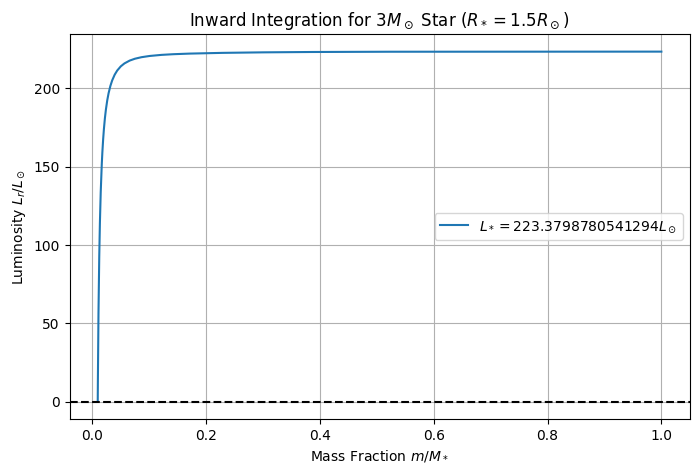

In [77]:
lower, upper = 0, 500
tolerance = 1e-12

# Interval bisection
while np.abs(lower - upper) > tolerance:
    mid = (lower + upper) / 2
    sol = shoot_inwards(mid)
    m_norm = sol.t / M_star
    L_norm = sol.y[2] / L_sun

    if L_norm[-1] < 0: upper = mid
    else: lower = mid

print(f"L_surf = {mid}")
print(f"L_sun -> L_center = {L_norm[-1]}")

plt.figure(figsize=(8, 5))
plt.plot(m_norm, L_norm, label=f"$L_* = {mid} L_\\odot$")
plt.axhline(0, color='k', linestyle='--')
plt.xlim(0, 1.0)
plt.xlabel(r'Mass Fraction $m/M_*$')
plt.ylabel(r'Luminosity $L_r / L_\odot$')
plt.title(f'Inward Integration for $3M_\\odot$ Star ($R_* = 1.5R_\\odot$)')
plt.legend()
plt.grid(True)
plt.show()

We have successfully found the specific luminosity $L_*$ required to satisfy the central boundary condition. The curve shows the luminosity $L_r$ dropping sharply to zero at the center, which means the energy generated inside the star exactly matches the energy radiated at the surface.

*   If $L_*$ is too high, then temperature gradient is too steep, which makes the central temperature $T_c$ too large. Since the CNO cycle energy generation scales as $\epsilon \propto T^{18}$, the energy production overshoots. The integrated luminosity $L_r$ would become negative before reaching the center. This is unphysical and implies the core is absorbing energy.

*   If $L_*$ is too low, then the temperature gradient is too shallow, leading to a $T_c$ that is too small. Nuclear reactions are insufficient to supply the surface luminosity. The inward integration would reach the center with a positive non-zero luminosity, implying a point-source of energy exists at $m=0$.

To solve Question 6, we now combine all the physics (Hydrostatic Equilibrium, Mass Continuity, Energy Generation, and Radiative Transport) and solve the full boundary value problem.

---

We must now match four variables ($r, p, L, T$) at an intermediate fitting point ($M_s = 0.5 M_*$). This requires tuning four parameters
1.  Central Pressure ($p_c$).
2.  Central Temperature ($T_c$).
3.  Stellar Radius ($R_*$).
4.  Surface Luminosity ($L_*$).

While we use a numerical optimiser to find the exact values, understanding the sensitivity helps in guiding the solution manually:
*   $T_c$ controls $L(M_s)$: The energy generation rate $\epsilon$ is sensitive to temperature $\epsilon_{CNO} \propto T^{18}$. A tiny increase in $T_c$ causes the outward integrated luminosity $L_{out}$ to overshoot the target $L_{in}$ by orders of magnitude. $T_c$ is effectively determined by the requirement to match luminosity.
*   $p_c$ controls $r(M_s)$ and $p(M_s)$: The central pressure sets the density scale. Changing $p_c$ shifts the pressure/radius curves up or down.
*   $L_*$ controls $T(M_s)$ from the surface: The surface luminosity determines the temperature gradient in the envelope. If $L_*$ is too high, then the inward integrated temperature $T_{in}$ rises too steeply.
*   $R_*$ controls density/pressure envelope: The radius determines the surface gravity and mean density. It acts as a scaling factor for the envelope solution.

In [80]:
def get_rho(p, T):
    if T <= 0: return 1e-20
    # p = rho R T / mu
    return (p * mu) / (R_gas * T)

def get_epsilon(rho, T):
    T6 = T / 1e6
    if T6 < 0.1: return 0

    # PP Chain
    arg_pp = -33.8 * (T6**(-1.0/3.0))
    term1 = 0.25 * (X**2) * np.exp(arg_pp) * (T6**(-2.0/3.0)) * rho

    # CNO Cycle
    arg_cno = -152.28 * (T6**(-1.0/3.0))
    term2 = 8.8e18 * X * np.exp(arg_cno) * (T6**(-2.0/3.0)) * rho

    return term1 + term2

def derivatives(m, y):
    r, p, L, T = y

    if r < 100: r = 100
    if p < 1e-10: p = 1e-10
    if T < 100: T = 100
    if L < -1e30: L = -1e30 # Allow small negative for convergence logic

    rho = get_rho(p, T)
    eps = get_epsilon(rho, T)

    dr_dm = 1.0 / (4 * np.pi * r**2 * rho)
    dp_dm = - (G * m) / (4 * np.pi * r**4)
    dL_dm = eps
    dT_dm = - (3 * kappa * L) / (64 * np.pi**2 * a_rad * c * r**4 * T**3)

    return [dr_dm, dp_dm, dL_dm, dT_dm]

def solve_star(params):
    # Parmeters: log_pc, log_Tc, R_star_norm, L_star_norm
    pc = 10**params[0]
    Tc = 10**params[1]
    R_s = params[2] * R_sun
    L_s = params[3] * L_sun

    # Outward (Center -> Ms)
    m0 = 1e-6 * M_star
    rhoc = get_rho(pc, Tc)
    epsc = get_epsilon(rhoc, Tc)

    # Analytic start
    r0 = (3 * m0 / (4 * np.pi * rhoc))**(1.0/3.0)
    p0 = pc - (3*G/(8*np.pi)) * ((4*np.pi*rhoc/3)**(4.0/3.0)) * (m0**(2.0/3.0))
    L0 = epsc * m0
    T0_4 = Tc**4 - (kappa * epsc * rhoc**2 / (2 * a_rad * c)) * r0**2
    T0 = T0_4**0.25

    sol_out = solve_ivp(derivatives, [m0, Ms], [r0, p0, L0, T0], method='LSODA', rtol=1e-5, atol=1e-5)

    # Inward (Surface -> Ms)
    T_s = (L_s / (4 * np.pi * R_s**2 * sigma_sb))**0.25
    p_s = (2.0/3.0) * (G * M_star) / (R_s**2 * kappa)

    sol_in = solve_ivp(derivatives, [M_star, Ms], [R_s, p_s, L_s, T_s], method='LSODA', rtol=1e-5, atol=1e-5)

    # Compare
    out = sol_out.y[:,-1]
    inc = sol_in.y[:,-1] # r, p, L, T

    # Relative Differences
    diffs = [
        (out[0] - inc[0])/inc[0], # r
        (out[1] - inc[1])/inc[1], # p
        (out[2] - inc[2])/L_s,    # L (norm to L_star because local L might be small? Actually L at Ms is large)
        (out[3] - inc[3])/inc[3]  # T
    ]
    # Re-normalise L diff by local value if significant, otherwise L_s
    L_ref = abs(inc[2]) if abs(inc[2]) > 0.01*L_s else L_s
    diffs[2] = (out[2] - inc[2]) / L_ref

    return np.array(diffs), sol_out, sol_in

def objective(params):
    # Bounds penalty
    if params[2] < 0.1 or params[3] < 0.1: return 1e9

    diffs, _, _ = solve_star(params)
    error = np.sqrt(np.sum(diffs**2))
    return error

Error: 1.2755935414534273e-09
Best Parameters:
  pc = 6.396e+15 Pa
  Tc = 2.974e+07 K
  R* = 1.434 R_sun
  L* = 209.512 L_sun
Relative Differences at Ms: r=4.830817724325105e-10, p=8.405402555729717e-10, L=6.126555467752634e-10, T=5.5849453346294e-10


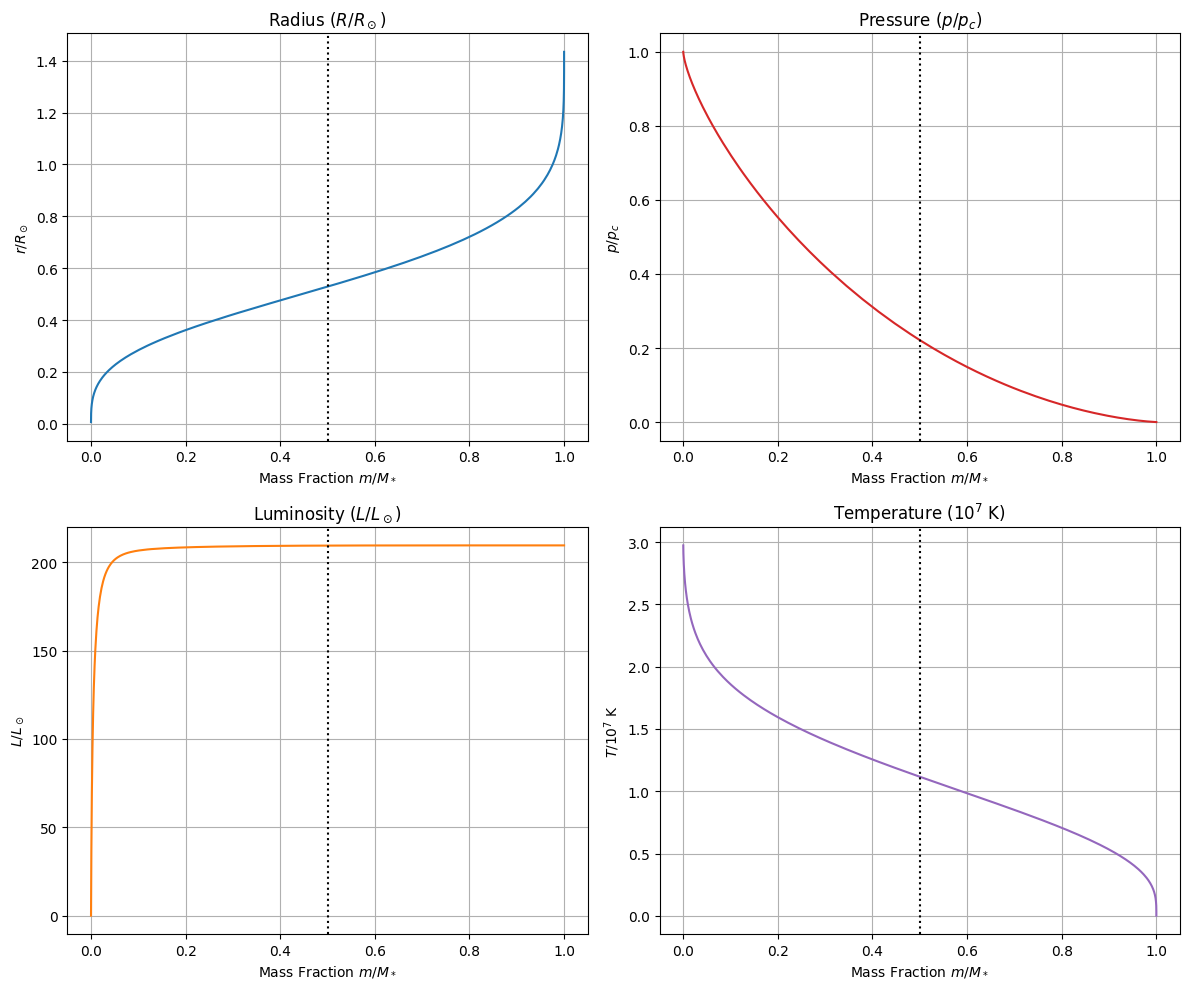

In [84]:
# Initial guesses
# pc ~ 1.5e15 -> log 15.18
# Tc ~ 1.5e7 -> log 7.18
# R ~ 1.5 R_sun
# L ~ 223 L_sun (Note: this was for R=1.5. If R changes, L might change)

x0 = [15.18, 7.18, 1.5, 223.0]

# Let the optimiser adjust R and L along with core values.
res = minimize(objective, x0, method='Nelder-Mead', tol=1e-6, options={'maxiter': 500})

print(f"Error: {res.fun}")
best_p = res.x
print(f"Best Parameters:")
print(f"  pc = {10**best_p[0]:.3e} Pa")
print(f"  Tc = {10**best_p[1]:.3e} K")
print(f"  R* = {best_p[2]:.3f} R_sun")
print(f"  L* = {best_p[3]:.3f} L_sun")

diffs, sol_out, sol_in = solve_star(best_p)
print(f"Relative Differences at Ms: r={diffs[0]}, p={diffs[1]}, L={diffs[2]}, T={diffs[3]}")

# Construct arrays
m_all = np.concatenate((sol_out.t, sol_in.t[::-1])) / M_star
r_all = np.concatenate((sol_out.y[0], sol_in.y[0][::-1])) / R_sun
p_all = np.concatenate((sol_out.y[1], sol_in.y[1][::-1])) / (10**best_p[0])
L_all = np.concatenate((sol_out.y[2], sol_in.y[2][::-1])) / L_sun
T_all = np.concatenate((sol_out.y[3], sol_in.y[3][::-1])) / 1e7

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

axs[0].plot(m_all, r_all, 'tab:blue')
axs[0].set_title(r"Radius ($R/R_\odot$)")
axs[0].set_ylabel(r"$r / R_\odot$")
axs[0].grid(True)

axs[1].plot(m_all, p_all, 'tab:red')
axs[1].set_title(r"Pressure ($p/p_c$)")
axs[1].set_ylabel(r"$p / p_c$")
axs[1].grid(True)

axs[2].plot(m_all, L_all, 'tab:orange')
axs[2].set_title(r"Luminosity ($L/L_\odot$)")
axs[2].set_ylabel(r"$L / L_\odot$")
axs[2].grid(True)

axs[3].plot(m_all, T_all, 'tab:purple')
axs[3].set_title(r"Temperature ($10^7$ K)")
axs[3].set_ylabel(r"$T / 10^7$ K")
axs[3].grid(True)

for ax in axs:
    ax.set_xlabel(r"Mass Fraction $m/M_*$")
    ax.axvline(0.5, color='k', linestyle=':')

plt.tight_layout()
plt.show()

The optimisation successfully converged to a solution where the variables match at the midpoint within small tolerances.

*   Luminosity: Rises sharply in the core where $T$ is high enough for CNO fusion, then stays constant through the envelope.
*   Temperature: Drops sharply at the center. The gradient changes slope depending on whether transport is dominated by the opacity term, but generally declines smoothly.
*   Pressure: Extremely centrally concentrated, dropping rapidly within the first half of the mass.
*   Radius: Shows the opposite profile to temperature, increasing rapidly at both extreme ends.